# CEM

In [1]:
import os,sys

parent = os.path.dirname(os.getcwd())
if parent not in sys.path:
    sys.path.append(parent)
print(parent)
%matplotlib widget

d:\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis


---

In [2]:
notebook_settings = {'evaluate_model':True, 'save_concepts': False, 'tsne':False, 'cd':False, 'explain': True}

### Model & Data

In [3]:
# Data

from src.datasets.BACH import BACH
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, KNNGraph
import torch
import numpy as np


graph_aug_val = Compose([KNNGraph(k=6)])


print('CUDA available: ', torch.cuda.is_available())
print('CUDA device count: ', torch.cuda.device_count())

src_folder = os.path.join(
    "C://Users", "aless", "Documents", "FtT", "data", "BACH_TRAIN")
tid,vid = BACH.get_train_val_ids(src_folder,"graph_orig.txt")
train_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=tid,pre_encoded=True)
val_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=vid,pre_encoded=True)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

print(len(train_loader))
print(len(val_loader))

CUDA available:  True
CUDA device count:  1
77
20


In [4]:
# Model

from src.deep_learning.architectures.cancer_prediction.cancer_gnn import CancerGNN
from src.deep_learning.architectures.cancer_prediction.explainable_cancer_gnn import ExplainableCancerGNN

#model = CancerGNN.load_from_checkpoint(os.path.join(parent,"model","GCN.ckpt"),WIDTH=32,HEIGHT=7)
#model = CancerGNN.load_from_checkpoint(os.path.join(parent,"model","FtTGCN85.ckpt"),WIDTH=64,HEIGHT=7)
model:ExplainableCancerGNN = None#CancerGNN.load_from_checkpoint(os.path.join(parent,"model","FtTGCN85.ckpt"),WIDTH=64,HEIGHT=7)


CancerGNN(
  (gnn): GCNx(
    (conv): ModuleList(
      (0): GCNConv(64, 64)
      (1): GCNConv(64, 64)
      (2): GCNConv(64, 64)
      (3): GCNConv(64, 64)
      (4): GCNConv(64, 64)
      (5): GCNConv(64, 64)
      (6): GCNConv(64, 64)
    )
    (transform): ModuleList(
      (0): Sequential(
        (0): BatchNorm1d(312, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=312, out_features=64, bias=True)
      )
      (1): Sequential(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Dropout(p=0, inplace=False)
        (3): Linear(in_features=64, out_features=64, bias=True)
      )
      (2): Sequential(
        (0): BatchNorm1d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Dropout(p=0, inplace=False)
        (3): Linear(in_features=64, out_feat

In [5]:
from torch_geometric.data import Batch, Data

def loader_from_one_graph(graph:Data):
    return DataLoader([graph], batch_size=1, shuffle=False)

def extract_graph(batch: Batch, graph_idx: int):
    # Find node indices for the graph
    node_mask = batch.batch == graph_idx

    # Extract the node features for the graph
    x = batch.x[node_mask]

    # Find edge indices for the graph
    edge_mask = node_mask[batch.edge_index[0]] & node_mask[batch.edge_index[1]]
    edge_index = batch.edge_index[:, edge_mask]

    # Re-map edge indices to the new node index space
    edge_index = edge_index - node_mask.nonzero(as_tuple=False).min()

    # If the batch contains other attributes, extract them similarly
    # ...
    y = batch.y[graph_idx]
    pos = batch.pos[node_mask]

    # Create a new Data object for the single graph
    single_graph = Data(x=x, edge_index=edge_index, y=y,pos=pos)
    single_graph.original_image_path = batch.original_image_path[graph_idx] 
    return single_graph

def batch_to_graphs(batch:Batch):
    num_graphs = batch.batch.max().item()
    for ind in range(num_graphs):
        yield extract_graph(batch,ind)

---

### Get Raw Activations

In [6]:
model_width = model.width
print("Model Width: ",model_width)

Model Width:  64


In [7]:
from tqdm import tqdm
from torch import softmax

class RawActivationHook:
    def __init__(self,width,device='cuda'):
        self.activations = torch.zeros(0,width).to(device)
    
    def append_activations(self, model,input, output):
        self.activations = torch.cat((self.activations,output),dim=0)
        
    def __enter__(self):
        self.remove_handle = model.gnn.conv[-1].register_forward_hook(lambda m,i,o:(self.append_activations(m,i,o)))
        return self
    
    def __exit__(self, type, value, traceback):
        self.remove_handle.remove()
        
    def get_activations(self) -> torch.Tensor:
        return self.activations

class ModelForward:
    def __init__(self,model,verbose=False):
        self.model = model
        self.model_width  = model.width
        self.model.eval()
        self.model.to('cuda')
        self.verbose = verbose
        
    def forward_node_level(self,loader):
        # Acquire the activations
        hook = RawActivationHook(self.model_width)


        
        predictions = torch.zeros(0).to('cuda')
        ground = torch.zeros(0).to('cuda')
        
        with hook:
            for batch in tqdm(loader,disable=not self.verbose):
                batch = batch.to('cuda')
                output = model.forward(batch.x,batch.edge_index,batch.batch)
                
                node_probs = softmax(output,dim=1)[batch.batch]
                node_ground = batch.y[batch.batch]
                
                
                predictions = torch.cat([predictions,node_probs])
                ground = torch.cat([ground,node_ground])
            
        raw_activations = hook.get_activations()
        return raw_activations.cpu().detach().numpy(),predictions.cpu().detach().numpy(),ground.cpu().detach().numpy().astype(int)
    
    def forward_graph_level(self,loader):
        predictions = torch.zeros(0).to('cuda')
        ground = torch.zeros(0).to('cuda')
        
        for batch in tqdm(loader,disable=not self.verbose):
            batch = batch.to('cuda')
            output = model.forward(batch.x,batch.edge_index,batch.batch)
            
            graph_probs = softmax(output,dim=1)
            graph_ground = batch.y
            
            predictions = torch.cat([predictions,graph_probs])
            ground = torch.cat([ground,graph_ground])
            
        return predictions.cpu().detach().numpy(),ground.cpu().detach().numpy().astype(int)

forwarder = ModelForward(model)

graph_prob_predictions_train,graph_ground_train = forwarder.forward_graph_level(train_loader)
graph_prob_predictions_val,graph_ground_val = forwarder.forward_graph_level(val_loader)

activations_train,node_predictions_train,node_ground_train  = forwarder.forward_node_level(train_loader)
activations_val,node_predictions_val,node_ground_val = forwarder.forward_node_level(val_loader)

Model accuracy on validation set: 0.8205128205128205
Model accuracy on training set: 0.9315960912052117


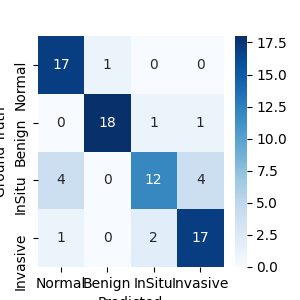

In [110]:
from src.deep_learning.metrics.confusion_matrix import confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

if notebook_settings['evaluate_model']:
    graph_predictions_train = np.argmax(graph_prob_predictions_train,axis=1)
    graph_predictions_val = np.argmax(graph_prob_predictions_val,axis=1)
    print(f"Model accuracy on validation set: {np.sum(graph_predictions_val == graph_ground_val)/len(graph_ground_val)}")
    print(f"Model accuracy on training set: {np.sum(graph_predictions_train == graph_ground_train)/len(graph_ground_train)}")

    con_mat = confusion_matrix(torch.tensor(graph_ground_val),torch.tensor(graph_predictions_val),4)
    # plot confusion matrix with axis labels
    fig = plt.figure(figsize=(3,3))
    heatmap(con_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    labels = ['Normal','Benign','InSitu','Invasive']
    # put the major ticks at the middle of each cell
    plt.xticks(np.arange(4)+0.5, labels, rotation=0)
    plt.yticks(np.arange(4)+0.5, labels, rotation=90)
    
    # remove legends
        
    
    plt.show()

---
# K Means

In [9]:
import numpy as np
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans

class ConceptDiscoverer:
    def __init__(self,num_concepts,mixture=True,verbose=True,whiten=True,**kwargs) -> None:
        self.k = num_concepts
        if mixture:
            self.gm = BayesianGaussianMixture(n_components=self.k,verbose=verbose,**kwargs)
        else:
            self.gm = MiniBatchKMeans(n_clusters=self.k,verbose=verbose,**kwargs)
            
        self.is_mixture = mixture
        
        self.whiten_act = whiten
        
    def fit(self,activations: np.ndarray):
        self.mu = activations.mean(axis=0)
        self.sigma = activations.std(axis=0)
        
        whitten_activations = self.whiten(activations)        
        self.gm.fit(whitten_activations)
    
    def get_concept_distances(self,activations):
        whittened = self.whiten(activations)
        if self.is_mixture:
            probs = self.gm.predict_proba(whittened)
            #Ensure no zero probabilities
            probs[probs == 0] = 1e-10
            return -np.log(probs)
        else:
            return self.gm.transform(whittened)
            
    def predict(self,activations):
        whitten_activations = self.whiten(activations)
        return self.gm.predict(whitten_activations)
    
    def silouhette_score(self,activations,**kwargs):
        whitten_activations = self.whiten(activations)
        return silhouette_score(whitten_activations,self.gm.predict(whitten_activations),**kwargs)
        
    def whiten(self,obs):
        if(self.whiten_act):
            return (obs - self.mu)/self.sigma
        else:
            return obs



In [10]:
if notebook_settings['cd']:
    sub_sample_size = 1000
    sub_sample = np.random.choice(activations_train.shape[0],sub_sample_size,replace=False)

    num_concepts =64

    cd = ConceptDiscoverer(num_concepts=num_concepts)
    cd.fit(activations_train[sub_sample])
    print(cd.get_concept_distances(activations_train[sub_sample]))

In [11]:
if notebook_settings['cd']:
    #train_concept_probs = cd.predict_proba(activations_train)
    #val_concept_probs = cd.predict_proba(activations_val)

    train_concepts = cd.predict(activations_train)
    val_concepts = cd.predict(activations_val)

## Rejection Sampling
What if we consider only those activations that are we have a certain degree of confidence is in that concept?

In [12]:
def within_acceptance(probabilities:np.ndarray,threshold = 0.99):
    max_prob = probabilities.max(axis=1)
    assert(max_prob.shape[0] == probabilities.shape[0])
    number_surpass = (max_prob > threshold).sum()
    return number_surpass / probabilities.shape[0]

#print("Train: ",within_acceptance(train_concept_probs))
#print("Val: ",within_acceptance(val_concept_probs))

In [13]:
if notebook_settings['save_concepts']:
    np.save("mu.npy",mu)
    np.save("sigma.npy",sigma)

---
# Vizualize Explanations

In [14]:

from sklearn.manifold import TSNE


if notebook_settings['tsne']:
    tsne_sample_size  = 50000
    tsne_sample= np.random.choice(activations_train.shape[0],tsne_sample_size,replace=False)
    position_tsne_sample =TSNE(n_components=2,verbose=2,perplexity = 2000,n_iter=500).fit_transform(activations_train[tsne_sample])


In [15]:

import matplotlib.pyplot as plt
from matplotlib import cm

def plot_tsne_points_with_category(points,classes):
    f = plt.figure(figsize=(10,10))
    # How many different classes are there
    unique_classes = np.unique(classes)
    colours = cm.rainbow(np.linspace(0,1,len(unique_classes)))
    
    # Group the points by their class and then plot all points of the same class at a time
    for i,cl in enumerate(unique_classes):
        points_with_class = (classes==cl)
        v = points[points_with_class]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])

    plt.show()

In [16]:
if notebook_settings['tsne']:
    prediction_tsne_sample = node_predictions_train[tsne_sample].argmax(axis=1)
    ground_tsne_sample = node_ground_train[tsne_sample]
    
    k = 64
    cd = ConceptDiscoverer(num_concepts=k,verbose=False)
    cd.fit(activations_train)
    hard_concept_tsne_sample = cd.predict(activations_train[tsne_sample])

    print(prediction_tsne_sample.shape)
    plot_tsne_points_with_category(position_tsne_sample,ground_tsne_sample)
    plot_tsne_points_with_category(position_tsne_sample,hard_concept_tsne_sample)

---
# Concept Completeness

In [17]:
def one_hot_concept(concept_ids,num_concepts):
    one_hot = np.zeros((len(concept_ids),num_concepts))
    one_hot[np.arange(len(concept_ids)),concept_ids] = 1
    return one_hot

In [18]:


# Takes every observed concept along with the eventual graph prediction and then generates X,Y pairs for training a classifier
def generate_concept_to_prediction_map(model,cd,loader):
    f = ModelForward(model)
    act,pred_prob,ground =  f.forward_node_level(loader)
    
    return cd.predict_proba(act),ground
    

In [19]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

class ConceptNodeCancerPredictor:
    def __init__(self,k):
        self.dt = DecisionTreeClassifier(max_leaf_nodes=k)
        self.k = k
        
    
    def fit(self,concepts,graph_ground):
        self.dt.fit(concepts.reshape(-1,1),graph_ground)

    
    def predict(self,concepts):
        return self.predict_proba(concepts.reshape(-1,1)).argmax(axis=1)
    
    def predict_proba(self,concepts):
        return self.dt.predict_proba(concepts)
    
    def get_concept_prob_of_cancer(self):
        return self.dt.predict_proba(np.arange(self.k).reshape(-1,1))

class ConceptGraphClassPredictor:
    def __init__(self,k,trained_model,trained_concept_discoverer, trained_node_graph_class_predictor):
        self.node_predictor = ConceptNodeCancerPredictor(k)
        self.k = k
        self.forwarder = ModelForward(trained_model)
        self.cd = trained_concept_discoverer
        self.node_predictor = trained_node_graph_class_predictor
        
    def get_graph_concept_distribution(self, graph, rejection_threshold = 0.99):
        act,pred_prob,ground = self.forwarder.forward_node_level(loader_from_one_graph(graph))
        graph_pred = pred_prob[0]
        graph_ground = ground[0]
        #ensure graph ground is flattened
        ground = ground.reshape(-1)

        concept_prob = one_hot_concept(self.cd.predict(act),self.k)
        num_nodes = graph.x.shape[0]
        
        assert concept_prob.shape == (num_nodes,self.k)
        
                
        # Filter out concepts that are not accepted
        accepted = (concept_prob.max(axis=1) > rejection_threshold)
        num_remaining_nodes =  accepted.sum()
        
        assert accepted.shape == (num_nodes,)
        concept_prob = concept_prob[accepted]
        assert concept_prob.shape == (num_remaining_nodes,self.k)
        pred_prob = pred_prob[accepted]
        assert pred_prob.shape == (num_remaining_nodes,4)
        ground = ground[accepted]
        assert ground.shape == (num_remaining_nodes,)
        
        concept_dist = concept_prob.mean(axis=0)
        assert concept_dist.shape == (self.k,)
        
        
        # Graph-pred/ground is the prediction and ground truth for the graph (one value)
        # Node-pred/ground is the prediction and ground truth for the graph but one for each node
        return {'concept-dist':concept_dist,'node-pred':pred_prob, 'node-ground':ground, 'graph-pred':graph_pred, 'graph-ground':graph_ground, 'num-nodes':num_nodes, 'num-nodes-above-threshold':num_remaining_nodes}
    
    def vote_on_graph(self,graph,rejection_threshold = 0.99):
        prediction_info = self.get_graph_concept_distribution(graph,rejection_threshold)
        concept_prob_of_class = self.node_predictor.get_concept_prob_of_cancer()
        # Perform a weighted sum vote
        assert prediction_info['concept-dist'].shape == (self.k,)
        
        weighted_sum = prediction_info['concept-dist'].reshape(-1,1)*concept_prob_of_class
        
        assert concept_prob_of_class.shape == (self.k,4)
        
        assert weighted_sum.shape == (self.k,4)
        vote = weighted_sum.sum(axis=0)
                
        assert vote.shape == (4,)
        prediction_info['concept-vote'] = vote
        return prediction_info


Q: For a particular graph, what concepts are present, how many times for each, and what is the contribution of that concept

In [20]:
if False:
    cncp = ConceptNodeCancerPredictor(num_concepts)
    cncp.fit(train_concepts,node_ground_train)
    cgcp = ConceptGraphClassPredictor(num_concepts,model,cd,cncp)
    

In [21]:
if notebook_settings['evaluate_model']:
    random_graph_id = np.random.randint(len(val_loader))
    graph = train_loader.dataset[random_graph_id]

    prediction_info = cgcp.vote_on_graph(graph)

    graph_concept_vote = prediction_info['concept-vote']

    graph_ground = prediction_info['graph-ground']
    graph_prediction = prediction_info['graph-pred']

    print("Ground: ",graph_ground)
    print("Prediction: ",graph_prediction.argmax().item(),graph_prediction)
    print("Concept vote: ",graph_concept_vote.argmax(),graph_concept_vote)

NameError: name 'cgcp' is not defined

In [22]:

# Import cross entropy and accuracy
from sklearn.metrics import accuracy_score,log_loss

# Across a whole dataset, let us evaluate how good the concept_voter is


class ConceptCompleteness:
    def __init__(self, trained_model,num_concepts,verbose = False,rejection_threshold=0.99,**kwargs):
        self.model = trained_model
        self.k = num_concepts
        self.max_samples_for_concept_discovery = kwargs.get('max_samples_for_concept_discovery',10000)
        self.forwarder = ModelForward(self.model,verbose=verbose)
        self.verbose = verbose
        self.rejection_threshold = rejection_threshold
        self.max_iter = kwargs.get('max_iter',200)
       
       
    def from_trainer(self,cd,cncp):
        self.cd = cd
        self.cncp = cncp
        self.cgcp = ConceptGraphClassPredictor(self.k,self.model,self.cd,self.cncp)
         
    def fit(self,loader):
        activations,node_pred,node_ground = self.forwarder.forward_node_level(loader)
        
        self.cd = ConceptDiscoverer(self.k,verbose=self.verbose,max_iter=self.max_iter)
        subset_of_activations = activations[np.random.choice(activations.shape[0],self.max_samples_for_concept_discovery,replace=False)]
        self.cd.fit(subset_of_activations)
        concepts = self.cd.predict(activations)
        
        self.cncp = ConceptNodeCancerPredictor(self.k)
        self.cncp.fit(concepts,node_ground)
            
        self.cgcp = ConceptGraphClassPredictor(self.k,self.model,self.cd,self.cncp)
        
    def evaluate(self,graph):
        prediction_info = self.cgcp.vote_on_graph(graph,self.rejection_threshold)
        return prediction_info['concept-vote'].argmax(),prediction_info['graph-ground']
            
        
    def completeness(self,loader):
        Y_HAT = []
        Y = []
        for batch in tqdm(loader,disable=not self.verbose):
            for graph_id in range(batch.batch.max()):
                graph = extract_graph(batch,graph_id)
                vote,ground = self.evaluate(graph)
                Y_HAT.append(vote)
                Y.append(ground)
        matches = np.equal(np.array(Y),np.array(Y_HAT)).sum()
        return matches/len(Y)
    
                
    



In [23]:
if True:
    num_concepts = 64
    completeness = ConceptCompleteness(model,num_concepts,max_samples_for_concept_discovery=10000)
    completeness.fit(train_loader)
    print(completeness.completeness(val_loader))

c:\Users\aless\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


0.7758620689655172


# Determine K
- Perform GM
- Get Concept Completeness
- Plot

In [24]:
if False:
    k_to_inspect = [16,32,64,128,256,512]
    completeness_scores = []

    for k in k_to_inspect:
        completeness = ConceptCompleteness(model,k,max_samples_for_concept_discovery=50000)
        completeness.fit(train_loader)
        score = completeness.completeness(val_loader)
        completeness_scores.append((k,score))   
        print(f"K: {k}, , Score: {score}")    
        

In [25]:
if False:
    print(completeness_scores)
    plt.plot(k_to_inspect,completeness_scores)

## Using Silhoutte Average

In [26]:
def get_n_points(n,data):
    return data[np.random.choice(data.shape[0],n,replace=False)]

In [27]:
if False:
    k_to_inspect = [2,4,8,16,32,64]

    n= 10000
    scores = []
    for k in k_to_inspect:
        for mixture in [True,False]:
            cd = ConceptDiscoverer(k,verbose=False,whiten=True,max_iter=2000,mixture=mixture)
            cd.fit(get_n_points(n,activations_train))
            siho_avg = cd.silouhette_score(activations_train,sample_size=n)
            scores.append((k,mixture,siho_avg))
            print(f"K: {k}, Mixture: {mixture}, Score: {siho_avg}")


# Concept Representation



In [28]:
def create_concept_dist(inp,k):
    concept_dist = np.zeros(k)
    #If graph is a Data
    if type(inp) == Data:
        graph:Data = inp
        for node_id in range(graph.x.shape[0]):
            concept_dist[graph.concepts[node_id]] += 1
    else:
        for node_id in range(inp.shape[0]):
            concept_dist[inp[node_id]] += 1
    return concept_dist

class ConceptGraphGenerator:
    def __init__(self,model_forwarder,concept_discoverer):
        self.forwarder = model_forwarder
        self.cd = concept_discoverer
        
    def generate_concept_graph(self,graph):
        # 1) Get the activations for the graph
        act,pred_prob,ground = self.forwarder.forward_node_level(loader_from_one_graph(graph))
        # 2) Get the concepts
        concepts = self.cd.predict(act)
        graph.concepts = concepts
        graph.activations = act
         


In [29]:
if False:
    num_concepts =50

    cd = ConceptDiscoverer(num_concepts=num_concepts,mixture=False,verbose=False,max_iter=2000)
    max_train_points = 100000
    cd.fit(get_n_points(max_train_points,activations_train))
    cgg = ConceptGraphGenerator(ModelForward(model),cd)

In [30]:
class TopN:
    def __init__(self, n, key=lambda x:x):
        self.n = n
        self.container = []
        self.key = key
        
    def add(self, element,verbose= False):
        old_top = self.container[0] if len(self.container) > 0 else None
        self.container.append(element)
        self.container.sort(reverse=True, key=self.key)
        if len(self.container) > self.n:
            self.container = self.container[:self.n]
        new_top = self.container[0]
        if new_top != old_top and verbose:
            print(f"New top: {self.key(new_top)}")
        # Ensure that all elements are unique
        assert len(set(self.container)) == len(self.container)
        
    
    def get_top(self):
        return self.container
    
    def __str__(self):
        return str(self.container)


In [31]:
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.data import Data
import matplotlib.pyplot as plt
def extract_representation(graph,node_id,n):
    # Create a subgraph around the node
    subset,edges,_,_, = k_hop_subgraph(node_id,n,graph.edge_index,relabel_nodes=True)
    #
    subgraph = Data(x=graph.x[subset],edge_index=edges,pos=graph.pos[subset],y=graph.y)
    subgraph.concepts = graph.concepts[subset]
    # Load the image 
    subgraph.original_image_path = graph.original_image_path
    subgraph.node_id = node_id
    return subgraph
        
class ConceptRepresentationExtractor:
    def __init__(self,concept_graph_generator, concept_discoverer,verbose=False):
        self.cgg = concept_graph_generator
        self.cd = concept_discoverer
        self.k = self.cd.k
        self.verbose= verbose
        
    def generate_top_n_representations(self,loader,n,num_hops):
        # Hold a list of the top n representations for each of the k concepts
        top_n_representations = [TopN(n,lambda x:-x[0]) for i in range(self.k)]
        for batch in tqdm(loader,disable=not self.verbose):
            for graph in batch_to_graphs(batch):
                self.cgg.generate_concept_graph(graph)
                for node_id in range(graph.x.shape[0]):
                    subgraph = extract_representation(graph,node_id,num_hops)
                    concept = graph.concepts[node_id]
                    act = graph.activations[node_id].reshape(1,-1)
                    # Get the distance to the concept
                    concept_dist = self.cd.get_concept_distances(act)[0][concept]
                    
                    top_n_representations[concept].add((concept_dist,subgraph))
                    
        # For each concept, get the img of that neighbourhood
        
        return list(map(lambda x: x.get_top(),top_n_representations))
        



In [32]:
def one_example_per_graph(subgraphs:list[Data]):
    # Filter so that only the first example of each graph is kept
    paths = set()
    filtered = []
    for subgraph in subgraphs:
        if subgraph.original_image_path not in paths:
            filtered.append(subgraph)
            paths.add(subgraph.original_image_path)
            
    return filtered

def filter_only_in_class(subgraphs:list[Data],class_id):
    return list(filter(lambda x: x.y.item() == class_id,subgraphs))

In [33]:
if False:
    rep_extractor = ConceptRepresentationExtractor(cgg,cd)
    top_reps = rep_extractor.generate_top_n_representations(train_loader,20,3)



In [34]:
if False:
    print(len(top_reps[0]))
    print(len(one_example_per_graph(ignore_scores(top_reps[0]))))

In [35]:
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph,subgraph
import matplotlib.pyplot as plt


def gen_plot_graph_over_img(graph:Data,ax:plt.Axes,node_colours =None, crop_factor=64, crop_around_nodes=True,padding = 30,hide_nodes = True):

    # Load the tif image
    img = plt.imread(graph.original_image_path)
    # Crop the image
    img = img[crop_factor:-crop_factor,crop_factor:-crop_factor,:]
    # Plot the image on the subplot
    ax.imshow(img)
    
    
    # On top, plot each node & edge
    # Plot the nodes
    if not hide_nodes:
        ax.scatter(graph.pos[:,0],graph.pos[:,1],s=50,c='r' if node_colours is None else node_colours,alpha=0.5)
        # Plot the edges
        for edge in graph.edge_index.T:
            # Plot the edge, but make it faded
            ax.plot(graph.pos[edge,0],graph.pos[edge,1],c='r',alpha=0.5)
        
    # zoom into just the nodes
    if crop_around_nodes:
        ax.set_xlim(graph.pos[:,0].min()-padding,graph.pos[:,0].max()+padding)
        ax.set_ylim(graph.pos[:,1].min()-padding,graph.pos[:,1].max()+padding)
    # Give title to each subplot
    sample_name = graph.original_image_path.split('/')[-1]
    ax.set_title(f'{sample_name}'   )
    
        
    
    
def get_random_subgraph(graph:Data,n=3):
    # Get a random node id
    node_id = np.random.randint(0,graph.num_nodes)
    # Get the subgraph
    subset,edges,_,_ = k_hop_subgraph(node_id,n,graph.edge_index,relabel_nodes=True)
    # Create the subgraph
    subgraph = Data(x=graph.x[subset],edge_index=edges,pos=graph.pos[subset],original_image_path=graph.original_image_path)
    subgraph.graph_id = graph.graph_id
    return subgraph


In [36]:
#import cm
import matplotlib.cm as cm

def plot_all_concept_graphs(graphs:list[Data],hide_nodes = True):
    # Make a grid of figures
    fig,axs = plt.subplots(1,len(graphs),figsize=(7,7))
    k = num_concepts
    # For all k concepts, associate a random colour
    colours  = cm.rainbow(np.linspace(0,1,k))
    
    for i,graph in enumerate(graphs):
        axis = axs[i] if len(graphs) > 1 else axs
        node_colours = colours[graph.concepts]
        print(graph.original_image_path)
        gen_plot_graph_over_img(graph,axis,node_colours=node_colours,hide_nodes=hide_nodes)
    fig.tight_layout()
    fig.show()

def ignore_scores(inp:list[tuple]):
    return list(map(lambda x: x[1],inp))


In [37]:
# Purity
def purity_score(graph,concept):
    # compute what percentage of the nodes are of the concept
    return (graph.concepts == concept).sum()/graph.num_nodes

def get_average_purity(loader,k,rep_extractor):
    top_reps = rep_extractor.generate_top_n_representations(loader,20,2)
    pur = []
    for c in range(k):
        tot = 0
        for i,graph in enumerate(one_example_per_graph(ignore_scores(top_reps[c]))):
            tot += purity_score(graph,c)
        if(len(top_reps[c]) == 0):
            print("No graphs for concept: ",c)
        else:
            pur.append(tot/len(top_reps[c]))
    return np.mean(pur)



    

In [38]:
if False and notebook_settings['evaluate_model']:
    qty = 50000
    k_to_inspect = [2,4,8,16,32,64,128,256]
    for k in k_to_inspect:
        print("Investigating k: ",k)
        cd = ConceptDiscoverer(k,mixture=False,verbose=False,whiten=True,max_iter=2000)
        cd.fit(get_n_points(qty,activations_train))
        cgg = ConceptGraphGenerator(ModelForward(model),cd)
        rep_extractor = ConceptRepresentationExtractor(cgg,cd)

        # PURITY
        pur = get_average_purity(train_loader,k,rep_extractor)
        # SILO
        
        #siho_avg = cd.silouhette_score(activations_train,sample_size=qty)
        print(f"K: {k}, Purity: {np.mean(pur)}")
        

In [39]:
def train_explanation_resources(num_concepts):
    cd = ConceptDiscoverer(num_concepts=num_concepts,mixture=False,verbose=False,max_iter=2000)
    cd.fit(get_n_points(200000,activations_train))
    train_concepts = cd.predict(activations_train)

    cgg = ConceptGraphGenerator(ModelForward(model),cd)

    rep_extractor = ConceptRepresentationExtractor(cgg,cd)
    top_reps = rep_extractor.generate_top_n_representations(train_loader,5,3)
    cncp = ConceptNodeCancerPredictor(num_concepts)
    cncp.fit(train_concepts,node_ground_train)
    
    return cd,top_reps,cncp

In [40]:
sample = extract_graph(next(iter(val_loader)),2)
sample

Data(x=[935, 312], edge_index=[2, 5610], y=0, pos=[935, 2], original_image_path='C://Users\aless\Documents\FtT\data\BACH_TRAIN\Normal\n082.tif')

In [41]:
def get_most_exemplary_node(graph:Data,concept_id,cd):
    # Find the node with the highest concept probability
    concept_prob = cd.get_concept_distances(graph.activations)[:,concept_id]
    # Find the node with the highest concept probability
    node_id = int(np.argmin(concept_prob))
    return node_id

class GCExplainer:
    def __init__(self,model_forwarder,concept_discoverer, top_reps,concept_to_pred):
        self.forwarder = model_forwarder
        self.cd = concept_discoverer
        self.k = self.cd.k
        self.top_reps = top_reps
        self.cncp = concept_to_pred
        
    def explain_graph(self,graph:Data):
        # 1) Get the activations for the graph
        pred_prob,y =  self.forwarder.forward_graph_level(loader_from_one_graph(graph))
        y_hat = pred_prob[0].argmax()
        print(f"Predicted class: {y_hat}, Ground truth: {y}")
        act,node_pred_prob,ground = self.forwarder.forward_node_level(loader_from_one_graph(graph))
        # 2) Get the concepts
        concepts = self.cd.predict(act)
        graph.concepts = concepts
        graph.activations = act
        # Print concept dist
        self.print_extracted_concept_dist(graph)
        
        
        top_concepts = self.order_concepts(graph)
        
        concepts_outputted = 0 
        for c in top_concepts:
            if concepts_outputted > 4:
                break
            similiar_graphs = filter_only_in_class(one_example_per_graph(ignore_scores(self.top_reps[c])),y_hat)
            #Select only 3 
            similiar_graphs = similiar_graphs[:3]
            if len(similiar_graphs)!=0:
                print(f"Concept {c}: ")
                exemplary_node = get_most_explempary_node(graph,c,self.cd)
                exemplary_rep = extract_representation(graph,exemplary_node,3)
                fig,axs = plt.subplots(1,1,figsize=(7,7))
                axs.set_title(f"From IMG")
                gen_plot_graph_over_img(exemplary_rep,axs,hide_nodes=True)
                plot_all_concept_graphs(similiar_graphs,hide_nodes=True)
                concepts_outputted += 1
        # Render some graphs
        self.render_graph(graph)
            


        

    

    
    def order_concepts(self,graph:Data,y_hat=0,n=3):
        # Just go for the top 3 most prevelant concepts
        concept_dist = create_concept_dist(graph,self.k)
        top_concepts = np.argsort(concept_dist)[-1::-1]
        return top_concepts        
        
    def print_extracted_concept_dist(self,graph:Data):
        # Tabulate the concepts
        concept_dist = create_concept_dist(graph,self.k)
            
        print("Concept distribution: ")
        for i in range(self.k):
            if concept_dist[i] > 0:
                concept_probs = self.cncp.get_concept_prob_of_cancer()[i]
                print(f"Concept {i}: {concept_dist[i]} - {concept_probs}")
            
        
        
    def render_graph(self,graph:Data):
        fig,ax = plt.subplots(1,1,figsize=(20,20))
        
        gen_plot_graph_over_img(graph,ax,node_colours=graph.concepts,hide_nodes=False)
        ax.axis('off')
        fig.show()

if notebook_settings['explain'] and False:
    explainer = GCExplainer(ModelForward(model),cd,top_reps,cncp)
    explainer.explain_graph(sample)

## LEN

In [42]:
def graph_to_concept_dist(graph:Data,k,forwarder,cd):
    # Get the activations
    activaitons,_,_ = forwarder.forward_node_level(loader_from_one_graph(graph))
    # Get the concepts
    concepts = cd.predict(activaitons)
    # Get the concept distribution
    concept_dist = create_concept_dist(concepts,k)
    return concept_dist
    

def load_dataset(cd,loader,forwarder):
    x = []
    y = []
    # For each graph
    for batch in tqdm(loader):
        for graph in batch_to_graphs(batch):
            # Add to the dataset
            x.append(graph_to_concept_dist(graph,cd.k,forwarder,cd))
            y.append(graph.y)
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    # y = one_hot(y.to(torch.int64),num_classes=classes)
    return x,y



In [130]:
from lens.models.mu_nn import XMuNN
from torch.utils.data import TensorDataset
from torch.nn.functional import one_hot

def apply_to_all_rows(x,func):
    return torch.stack([torch.Tensor(func(row)) for row in x])

class ConceptLogicExplainNetwork:
    def __init__(self,input_concepts,output_classes,hidden_neurons,concept_agg_normalizer,verbose = False) -> None:
        self.input_concepts = input_concepts
        self.output_classes = output_classes
        self.hidden_neurons = hidden_neurons
        self.loss = torch.nn.CrossEntropyLoss()
        self.can = concept_agg_normalizer
        self.verbose = verbose

    def fit(self,train_concept_dist,train_y,val_concept_dist,val_y,epochs=300,l_r=0.01,l1=0.1):
        
        train_dataset = self.dist_to_concept_dataset(train_concept_dist,train_y)
        val_dataset = self.dist_to_concept_dataset(val_concept_dist,val_y)
        self.model = XMuNN(self.output_classes,self.input_concepts,self.hidden_neurons,loss=self.loss,l1_weight=l1)
        self.model.fit(train_dataset,val_dataset,epochs=epochs,l_r=l_r,verbose=self.verbose,lr_scheduler=True,early_stopping=False)

    def predict(self,all_dist,all_y,x_dist,y =None ,simplify=True):
        return self.model.get_local_explanation(self.dist_to_concept(all_dist),all_y,self.dist_to_concept(x_dist),target_class=y,simplify=simplify)
        
    
    def evaluate(self,x_dist,y):
        return self.model.evaluate(self.dist_to_concept_dataset(x_dist,y))
    
    def global_explain(self,x_dist,y,target_class,val_dist_x=None,val_y=None):
        return self.model.get_global_explanation(self.dist_to_concept(x_dist),y,target_class=target_class,x_val=self.dist_to_concept(val_dist_x),y_val=val_y)
            
    
    def dist_to_concept(self,dist):
        return torch.tensor(apply_to_all_rows(dist,self.can))
    
    def dist_to_concept_dataset(self,x_dist,y):
        return TensorDataset(self.dist_to_concept(x_dist),y)
    

        
def top_k_norm(dist,k):
    low_concepts = np.argsort(dist)
    high_concepts = low_concepts[-k:]
    output = np.zeros(dist.shape)
    output[high_concepts] = 1
    return output

def above_threshold_norm(dist,threshold):
    return ((dist/dist.sum()) > threshold).int().float()

def sum_norm(dist):
    return dist/dist.sum()

def soft_norm(dist,t):
    # First sum_norm to get probabilities
    probs = sum_norm(dist)
    # Then divide by the max
    normed =  probs/(probs.max()+1e-10)
    return (normed > t).int().float()

harden = lambda x: above_threshold_norm(x,0)







In [45]:
def plot_example_reps_for_concepts(top_rep,concept_id,cl=None):
    top = top_rep[concept_id]
    graphs = one_example_per_graph(ignore_scores(top))
    if cl is not None:
        graphs = filter_only_in_class(graphs,cl)
    plot_all_concept_graphs(graphs,hide_nodes=True)

In [91]:
if True:
    concepts_to_explore = [64,128,256,512]
    
    normalizers = {'top_1':lambda x: top_k_norm(x,1),
               'top_3':lambda x: top_k_norm(x,3),
               'top_5':lambda x: top_k_norm(x,5),
               'top_10':lambda x: top_k_norm(x,10),
               'harden':harden,
               'above_0.05':lambda x: above_threshold_norm(x,0.05),
               'above_0.1':lambda x: above_threshold_norm(x,0.1),
               'above_0.2':lambda x: above_threshold_norm(x,0.2),
               'sum_norm': sum_norm}
    scores = {}
    epochs =500
    for i in range(5):
        for k in concepts_to_explore:
            cd,top_reps,_ = train_explanation_resources(num_concepts)
            train_concepts_dist,train_y = load_dataset(cd,train_loader,ModelForward(model))
            val_concepts_dist,val_y = load_dataset(cd,val_loader,ModelForward(model))

            for name,func in normalizers.items():
                print(f"Training {name} for {k} concepts, iteration {i}")
                lens = ConceptLogicExplainNetwork(num_concepts,4,[32],func)
                lens.fit(train_concepts_dist,train_y,val_concepts_dist,val_y,epochs=epochs)
                score = lens.evaluate(val_concepts_dist,val_y)
                print(f"Score for {name} k {k}: {score}")
                ky = (name,k)
                if ky not in scores:
                    scores[ky] = []
                scores[ky].append(score)
    print(scores)

100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Training top_1 for 32 concepts, iteration 0
Pruned 1/128 features
Pruned 1/128 features
Pruned 1/128 features
Pruned 1/128 features
Pruned features
Score for top_1 k 32: 51.724137931034484
Training top_1 for 32 concepts, iteration 1
Pruned 1/128 features
Pruned 1/128 features
Pruned 3/128 features
Pruned 0/128 features
Pruned features
Score for top_1 k 32: 56.896551724137936
Training top_1 for 32 concepts, iteration 2
Pruned 3/128 features
Pruned 0/128 features
Pruned 2/128 features
Pruned 3/128 features
Pruned features
Score for top_1 k 32: 55.172413793103445
Training top_1 for 32 concepts, iteration 3
Pruned 1/128 features
Pruned 1/128 features
Pruned 1/128 features
Pruned 1/128 features
Pruned features
Score for top_1 k 32: 51.724137931034484
Training top_1 for 32 concepts, iteration 4
Pruned 1/128 features
Pruned 2/128 features
Pruned 3/128 features
Pruned 2/128 features
Pruned features
Score for top_1 k 32: 56.896551724137936
Training top_3 for 32 concepts, iteration 0
Pruned 1/12

KeyboardInterrupt: 

In [290]:
num_concepts = 128
cd,top_reps,_ = train_explanation_resources(num_concepts)
train_concepts_dist,train_y = load_dataset(cd,train_loader,ModelForward(model))
val_concepts_dist,val_y = load_dataset(cd,val_loader,ModelForward(model))

100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


In [291]:
normer =  sum_norm
clen = ConceptLogicExplainNetwork(num_concepts,4,[16], normer,verbose=True)
clen.fit(train_concepts_dist,train_y,val_concepts_dist,val_y,epochs=200,l1=0.0001)
print(clen.evaluate(val_concepts_dist,val_y))


C:\Users\aless\AppData\Local\Temp/ipykernel_25816/2984708724.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(apply_to_all_rows(dist,self.can))


Epoch: 1/200, Loss: 1.422, Tr_acc: 26.09, Val_acc: 22.41, best_e: -1
Epoch: 2/200, Loss: 1.406, Tr_acc: 27.39, Val_acc: 29.31, best_e: -1
Epoch: 3/200, Loss: 1.391, Tr_acc: 43.91, Val_acc: 22.41, best_e: -1
Epoch: 4/200, Loss: 1.376, Tr_acc: 36.52, Val_acc: 18.97, best_e: -1
Epoch: 5/200, Loss: 1.360, Tr_acc: 33.48, Val_acc: 32.76, best_e: -1
Epoch: 6/200, Loss: 1.343, Tr_acc: 43.04, Val_acc: 44.83, best_e: -1
Epoch: 7/200, Loss: 1.326, Tr_acc: 63.04, Val_acc: 56.90, best_e: -1
Epoch: 8/200, Loss: 1.308, Tr_acc: 76.09, Val_acc: 62.07, best_e: -1
Epoch: 9/200, Loss: 1.289, Tr_acc: 80.43, Val_acc: 63.79, best_e: -1
Epoch: 10/200, Loss: 1.269, Tr_acc: 83.04, Val_acc: 65.52, best_e: -1
Epoch: 11/200, Loss: 1.248, Tr_acc: 84.35, Val_acc: 65.52, best_e: -1
Epoch: 12/200, Loss: 1.224, Tr_acc: 85.22, Val_acc: 67.24, best_e: -1
Epoch: 13/200, Loss: 1.199, Tr_acc: 85.65, Val_acc: 65.52, best_e: -1
Epoch: 14/200, Loss: 1.173, Tr_acc: 85.65, Val_acc: 67.24, best_e: -1
Epoch: 15/200, Loss: 1.145, T

In [300]:
sample = extract_graph(next(iter(val_loader)),3)

ConceptGraphGenerator(ModelForward(model),cd).generate_concept_graph(sample)

sample_concept_dist = torch.Tensor(graph_to_concept_dist(sample,num_concepts,ModelForward(model),cd))
graph_y_hat,graph_y =  ModelForward(model).forward_graph_level(loader_from_one_graph(sample))
sample_y = int(graph_y[0])
print(f"Predicted class: {graph_y_hat.argmax()}, Ground truth: {graph_y}")


Predicted class: 0, Ground truth: [0]


In [301]:
print(sample)

Data(x=[330, 312], edge_index=[2, 1980], y=0, pos=[330, 2], original_image_path='C://Users\aless\Documents\FtT\data\BACH_TRAIN\Normal\n033.tif', concepts=[330], activations=[330, 64])


In [306]:
#print all the dists that are abobe 0

normed_sample_dist = list({c:f"{i} - {c}" for i,c in enumerate(normer(sample_concept_dist)) if c > 0}.items())
normed_sample_dist.sort(reverse=True)
for m in normed_sample_dist:
    print(m)
print(f"The LEN predicts {clen.model.forward(sample_concept_dist.reshape(1,-1))}")
print("Local")
print(clen.predict(train_concepts_dist,train_y,sample_concept_dist,y=sample_y,simplify=True))
print("Global")
print(clen.global_explain(train_concepts_dist,train_y,target_class=sample_y,val_dist_x=val_concepts_dist,val_y=val_y))


(tensor(0.0939), '62 - 0.0939393937587738')
(tensor(0.0576), '95 - 0.057575758546590805')
(tensor(0.0576), '6 - 0.057575758546590805')
(tensor(0.0515), '0 - 0.05151515081524849')
(tensor(0.0485), '114 - 0.04848484694957733')
(tensor(0.0455), '99 - 0.04545454680919647')
(tensor(0.0455), '96 - 0.04545454680919647')
(tensor(0.0455), '76 - 0.04545454680919647')
(tensor(0.0364), '77 - 0.036363635212183')
(tensor(0.0364), '65 - 0.036363635212183')
(tensor(0.0364), '29 - 0.036363635212183')
(tensor(0.0333), '32 - 0.03333333507180214')
(tensor(0.0303), '36 - 0.03030303120613098')
(tensor(0.0273), '60 - 0.027272727340459824')
(tensor(0.0273), '2 - 0.027272727340459824')
(tensor(0.0242), '71 - 0.024242423474788666')
(tensor(0.0242), '11 - 0.024242423474788666')
(tensor(0.0212), '4 - 0.021212121471762657')
(tensor(0.0212), '17 - 0.021212121471762657')
(tensor(0.0182), '58 - 0.0181818176060915')
(tensor(0.0182), '45 - 0.0181818176060915')
(tensor(0.0182), '119 - 0.0181818176060915')
(tensor(0.0182

C:\Users\aless\AppData\Local\Temp/ipykernel_25816/2984708724.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(apply_to_all_rows(dist,self.can))


feature0000000002 & feature0000000006 & ~feature0000000027 & ~feature0000000030 & feature0000000032 & ~feature0000000038 & ~feature0000000046 & feature0000000047 & feature0000000050 & ~feature0000000055 & feature0000000062 & ~feature0000000072 & ~feature0000000075 & feature0000000076 & feature0000000087 & feature0000000093 & feature0000000095 & feature0000000096 & ~feature0000000101 & feature0000000103 & ~feature0000000105 & ~feature0000000108 & ~feature0000000109 & feature0000000111 & feature0000000112 & feature0000000114 & feature0000000120
Global
~feature0000000002 & ~feature0000000006 & ~feature0000000027 & ~feature0000000030 & ~feature0000000032 & ~feature0000000038 & ~feature0000000046 & ~feature0000000047 & ~feature0000000050 & ~feature0000000055 & ~feature0000000062 & ~feature0000000072 & ~feature0000000075 & ~feature0000000076 & ~feature0000000087 & ~feature0000000093 & ~feature0000000095 & ~feature0000000096 & ~feature0000000101 & ~feature0000000103 & ~feature0000000105 & ~fe

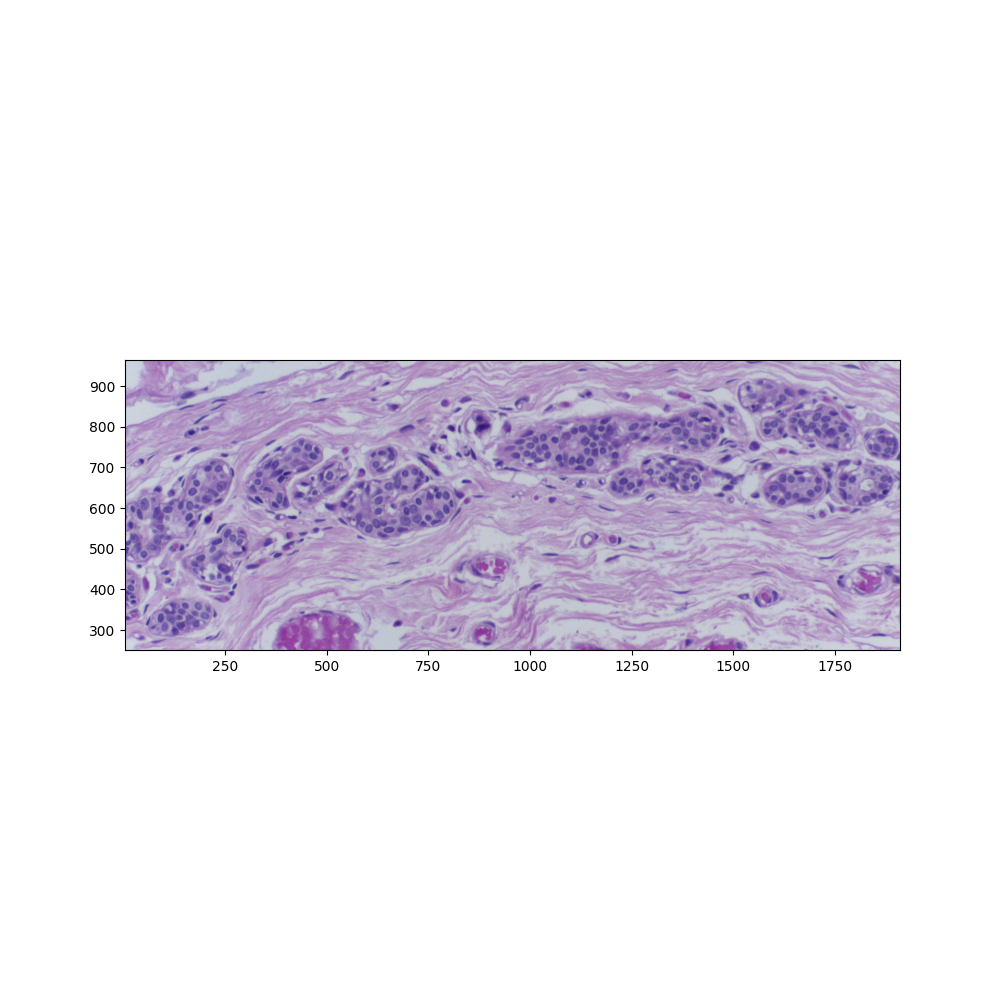

In [303]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
gen_plot_graph_over_img(sample,ax,hide_nodes=True)


C://Users\aless\Documents\FtT\data\BACH_TRAIN\Normal\n075.tif
C://Users\aless\Documents\FtT\data\BACH_TRAIN\InSitu\is076.tif
C://Users\aless\Documents\FtT\data\BACH_TRAIN\Normal\n085.tif
C://Users\aless\Documents\FtT\data\BACH_TRAIN\Normal\n070.tif


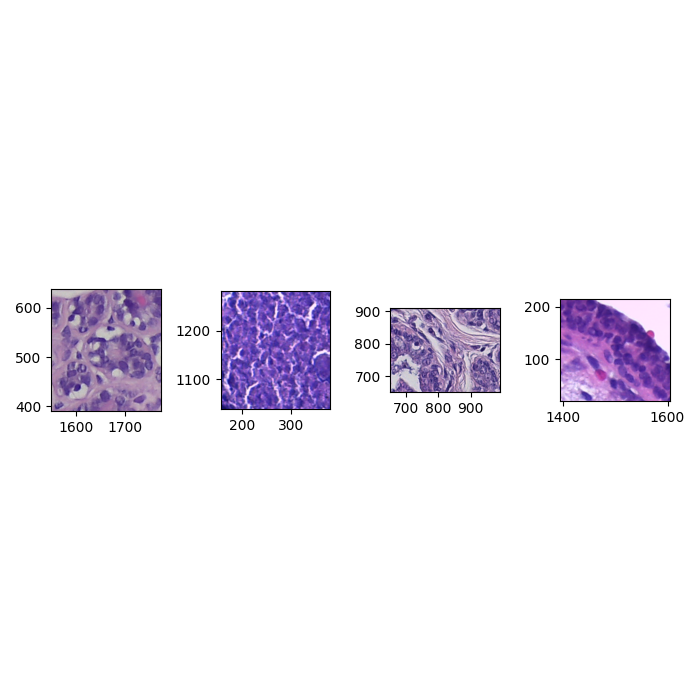

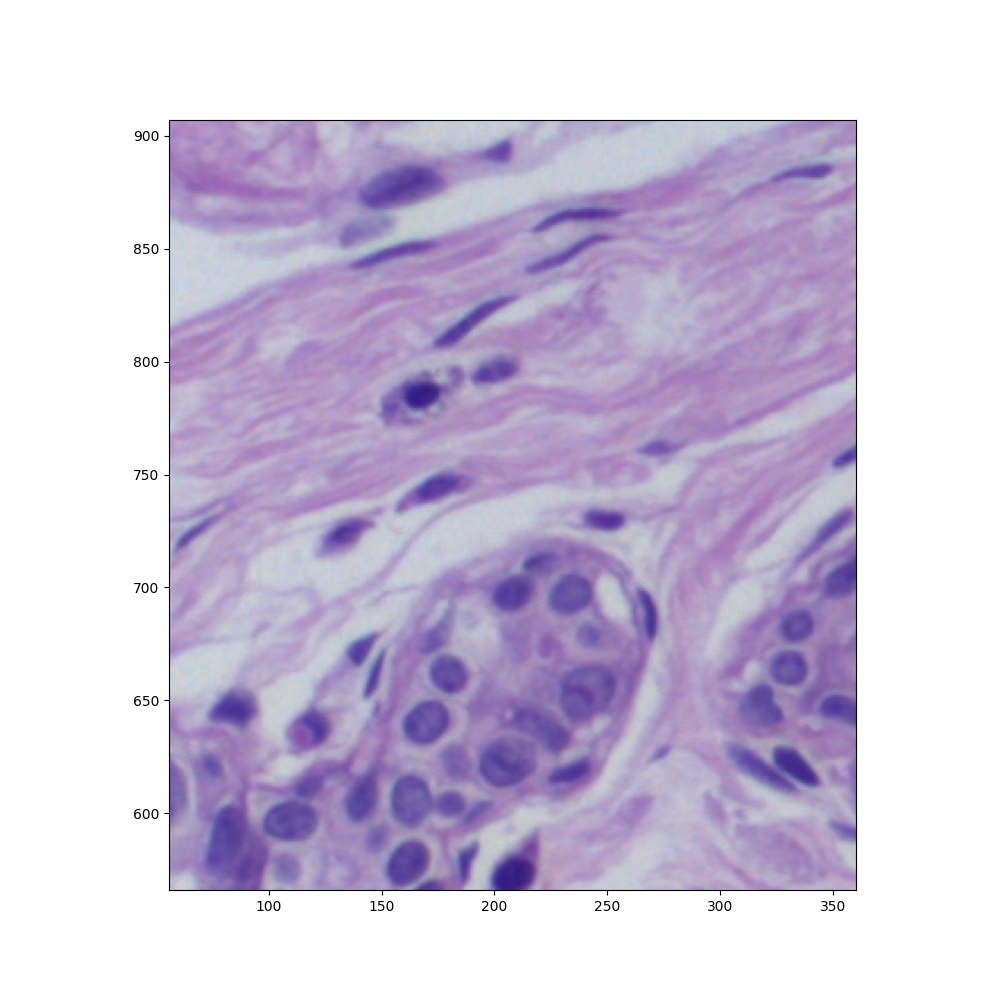

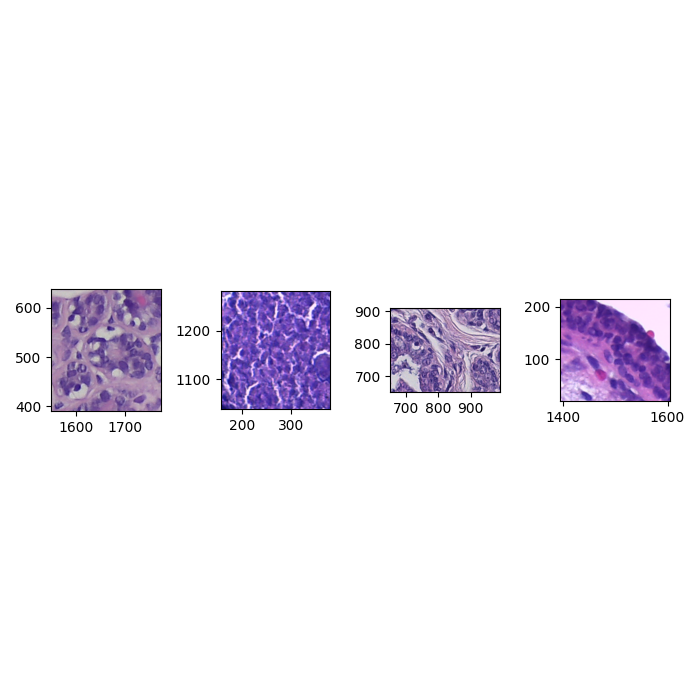

In [305]:
c = 95

# Plot concept from image
cgg = ConceptGraphGenerator(ModelForward(model),cd)

node = get_most_exemplary_node(sample,c,cd)
rep_to_show: Data = extract_representation(sample,node,3)

fig,ax = plt.subplots(1,1,figsize=(10,10))
gen_plot_graph_over_img(rep_to_show,ax,hide_nodes=True)


# Plot Exemplary
plot_example_reps_for_concepts(top_reps,c,cl=None)

is055

## Results:

In [230]:
#r = {('top_1', 32): [51.724137931034484, 53.44827586206896, 56.896551724137936], ('top_3', 32): [58.620689655172406, 55.172413793103445, 55.172413793103445], ('top_5', 32): [62.06896551724138, 56.896551724137936, 58.620689655172406], ('top_10', 32): [72.41379310344827, 74.13793103448276, 70.6896551724138], ('harden', 32): [62.06896551724138, 65.51724137931035, 68.96551724137932], ('above_0.05', 32): [67.24137931034483, 65.51724137931035, 60.3448275862069], ('above_0.1', 32): [53.44827586206896, 53.44827586206896, 58.620689655172406], ('above_0.2', 32): [46.55172413793103, 48.275862068965516, 39.6551724137931], ('sum_norm', 32): [79.3103448275862, 67.24137931034483, 75.86206896551724], ('top_1', 64): [46.55172413793103, 53.44827586206896, 58.620689655172406], ('top_3', 64): [58.620689655172406, 62.06896551724138, 63.793103448275865], ('top_5', 64): [63.793103448275865, 68.96551724137932, 70.6896551724138], ('top_10', 64): [72.41379310344827, 68.96551724137932, 68.96551724137932], ('harden', 64): [63.793103448275865, 62.06896551724138, 58.620689655172406], ('above_0.05', 64): [58.620689655172406, 48.275862068965516, 55.172413793103445], ('above_0.1', 64): [60.3448275862069, 65.51724137931035, 72.41379310344827], ('above_0.2', 64): [46.55172413793103, 44.827586206896555, 43.103448275862064], ('sum_norm', 64): [75.86206896551724, 82.75862068965517, 74.13793103448276], ('top_1', 128): [32.758620689655174, 60.3448275862069, 58.620689655172406], ('top_3', 128): [68.96551724137932, 65.51724137931035, 70.6896551724138], ('top_5', 128): [68.96551724137932, 65.51724137931035, 70.6896551724138], ('top_10', 128): [77.58620689655173, 67.24137931034483, 68.96551724137932], ('harden', 128): [70.6896551724138, 63.793103448275865, 63.793103448275865], ('above_0.05', 128): [72.41379310344827, 77.58620689655173, 74.13793103448276], ('above_0.1', 128): [65.51724137931035, 63.793103448275865, 63.793103448275865], ('above_0.2', 128): [56.896551724137936, 50.0, 44.827586206896555], ('sum_norm', 128): [77.58620689655173, 77.58620689655173, 79.3103448275862], ('top_1', 256): [44.827586206896555, 29.310344827586203, 44.827586206896555], ('top_3', 256): [63.793103448275865, 55.172413793103445, 60.3448275862069], ('top_5', 256): [68.96551724137932, 72.41379310344827, 68.96551724137932], ('top_10', 256): [63.793103448275865, 74.13793103448276, 72.41379310344827], ('harden', 256): [65.51724137931035, 63.793103448275865, 55.172413793103445], ('above_0.05', 256): [72.41379310344827, 77.58620689655173, 60.3448275862069], ('above_0.1', 256): [53.44827586206896, 56.896551724137936, 60.3448275862069], ('above_0.2', 256): [46.55172413793103, 44.827586206896555, 48.275862068965516], ('sum_norm', 256): [72.41379310344827, 77.58620689655173, 77.58620689655173], ('top_1', 512): [50.0, 39.6551724137931, 44.827586206896555], ('top_3', 512): [62.06896551724138, 67.24137931034483, 67.24137931034483], ('top_5', 512): [63.793103448275865, 72.41379310344827, 65.51724137931035], ('top_10', 512): [63.793103448275865, 65.51724137931035, 63.793103448275865], ('harden', 512): [67.24137931034483, 67.24137931034483, 65.51724137931035], ('above_0.05', 512): [58.620689655172406, 63.793103448275865, 58.620689655172406], ('above_0.1', 512): [70.6896551724138, 68.96551724137932, 53.44827586206896], ('above_0.2', 512): [44.827586206896555, 48.275862068965516, 48.275862068965516], ('sum_norm', 512): [81.03448275862068, 75.86206896551724, 79.3103448275862], ('top_1', 1024): [62.06896551724138, 44.827586206896555, 36.206896551724135], ('top_3', 1024): [58.620689655172406, 56.896551724137936, 63.793103448275865], ('top_5', 1024): [67.24137931034483, 67.24137931034483, 56.896551724137936], ('top_10', 1024): [65.51724137931035, 60.3448275862069, 68.96551724137932], ('harden', 1024): [68.96551724137932, 60.3448275862069, 65.51724137931035], ('above_0.05', 1024): [72.41379310344827, 60.3448275862069, 67.24137931034483], ('above_0.1', 1024): [65.51724137931035, 63.793103448275865, 56.896551724137936], ('above_0.2', 1024): [37.93103448275862, 41.37931034482759, 41.37931034482759], ('sum_norm', 1024): [75.86206896551724, 74.13793103448276, 68.96551724137932]}
r = {('top_1', 32): [51.724137931034484, 44.827586206896555, 43.103448275862064, 36.206896551724135, 36.206896551724135], ('top_3', 32): [60.3448275862069, 60.3448275862069, 65.51724137931035, 62.06896551724138, 58.620689655172406], ('top_5', 32): [63.793103448275865, 65.51724137931035, 60.3448275862069, 63.793103448275865, 60.3448275862069], ('top_10', 32): [63.793103448275865, 55.172413793103445, 58.620689655172406, 63.793103448275865, 62.06896551724138], ('harden', 32): [65.51724137931035, 65.51724137931035, 62.06896551724138, 65.51724137931035, 67.24137931034483], ('above_0.05', 32): [56.896551724137936, 65.51724137931035, 56.896551724137936, 53.44827586206896, 63.793103448275865], ('above_0.1', 32): [44.827586206896555, 43.103448275862064, 41.37931034482759, 32.758620689655174, 39.6551724137931], ('above_0.2', 32): [29.310344827586203, 31.03448275862069, 32.758620689655174, 32.758620689655174, 29.310344827586203], ('sum_norm', 32): [74.13793103448276, 70.6896551724138, 74.13793103448276, 74.13793103448276, 77.58620689655173], ('top_1', 64): [29.310344827586203, 39.6551724137931, 41.37931034482759, 48.275862068965516, 43.103448275862064], ('top_3', 64): [60.3448275862069, 65.51724137931035, 55.172413793103445, 63.793103448275865, 56.896551724137936], ('top_5', 64): [58.620689655172406, 63.793103448275865, 67.24137931034483, 67.24137931034483, 51.724137931034484], ('top_10', 64): [68.96551724137932, 58.620689655172406, 62.06896551724138, 70.6896551724138, 67.24137931034483], ('harden', 64): [60.3448275862069, 63.793103448275865, 62.06896551724138, 63.793103448275865, 65.51724137931035], ('above_0.05', 64): [65.51724137931035, 68.96551724137932, 60.3448275862069, 62.06896551724138, 50.0], ('above_0.1', 64): [50.0, 44.827586206896555, 46.55172413793103, 51.724137931034484, 44.827586206896555], ('above_0.2', 64): [27.586206896551722, 17.24137931034483, 20.689655172413794, 22.413793103448278, 27.586206896551722], ('sum_norm', 64): [70.6896551724138, 74.13793103448276, 72.41379310344827, 77.58620689655173, 68.96551724137932], ('top_1', 128): [34.48275862068966, 46.55172413793103, 43.103448275862064, 34.48275862068966, 41.37931034482759], ('top_3', 128): [65.51724137931035, 58.620689655172406, 56.896551724137936, 62.06896551724138, 62.06896551724138], ('top_5', 128): [67.24137931034483, 62.06896551724138, 63.793103448275865, 58.620689655172406, 58.620689655172406], ('top_10', 128): [60.3448275862069, 62.06896551724138, 72.41379310344827, 63.793103448275865, 62.06896551724138], ('harden', 128): [65.51724137931035, 65.51724137931035, 70.6896551724138, 68.96551724137932, 68.96551724137932], ('above_0.05', 128): [67.24137931034483, 67.24137931034483, 70.6896551724138, 68.96551724137932, 67.24137931034483], ('above_0.1', 128): [48.275862068965516, 46.55172413793103, 32.758620689655174, 50.0, 44.827586206896555], ('above_0.2', 128): [25.862068965517242, 32.758620689655174, 29.310344827586203, 32.758620689655174, 32.758620689655174], ('sum_norm', 128): [70.6896551724138, 77.58620689655173, 77.58620689655173, 77.58620689655173, 74.13793103448276], ('top_1', 256): [46.55172413793103, 39.6551724137931, 46.55172413793103, 51.724137931034484, 44.827586206896555], ('top_3', 256): [62.06896551724138, 63.793103448275865, 58.620689655172406, 67.24137931034483, 62.06896551724138], ('top_5', 256): [60.3448275862069, 62.06896551724138, 53.44827586206896, 62.06896551724138, 68.96551724137932], ('top_10', 256): [63.793103448275865, 56.896551724137936, 55.172413793103445, 72.41379310344827, 65.51724137931035], ('harden', 256): [63.793103448275865, 65.51724137931035, 65.51724137931035, 68.96551724137932, 56.896551724137936], ('above_0.05', 256): [67.24137931034483, 62.06896551724138, 65.51724137931035, 63.793103448275865, 63.793103448275865], ('above_0.1', 256): [44.827586206896555, 55.172413793103445, 43.103448275862064, 46.55172413793103, 43.103448275862064], ('above_0.2', 256): [29.310344827586203, 34.48275862068966, 36.206896551724135, 36.206896551724135, 34.48275862068966], ('sum_norm', 256): [75.86206896551724, 74.13793103448276, 72.41379310344827, 72.41379310344827, 72.41379310344827], ('top_1', 512): [32.758620689655174, 34.48275862068966, 37.93103448275862, 25.862068965517242, 25.862068965517242], ('top_3', 512): [50.0, 58.620689655172406, 60.3448275862069, 55.172413793103445, 56.896551724137936], ('top_5', 512): [55.172413793103445, 62.06896551724138, 65.51724137931035, 56.896551724137936, 63.793103448275865], ('top_10', 512): [60.3448275862069, 60.3448275862069, 67.24137931034483, 63.793103448275865, 67.24137931034483], ('harden', 512): [81.03448275862068, 67.24137931034483, 74.13793103448276, 70.6896551724138, 62.06896551724138], ('above_0.05', 512): [56.896551724137936, 58.620689655172406, 56.896551724137936, 63.793103448275865, 60.3448275862069], ('above_0.1', 512): [48.275862068965516, 53.44827586206896, 46.55172413793103, 51.724137931034484, 44.827586206896555], ('above_0.2', 512): [25.862068965517242, 25.862068965517242, 24.137931034482758, 24.137931034482758, 24.137931034482758], ('sum_norm', 512): [68.96551724137932, 68.96551724137932, 75.86206896551724, 70.6896551724138, 70.6896551724138]}
#r = {('top_1', 32): [62.06896551724138, 53.44827586206896, 62.06896551724138, 53.44827586206896, 60.3448275862069], ('top_3', 32): [75.86206896551724, 77.58620689655173, 77.58620689655173, 77.58620689655173, 77.58620689655173], ('top_5', 32): [68.96551724137932, 72.41379310344827, 70.6896551724138, 72.41379310344827, 68.96551724137932], ('top_10', 32): [70.6896551724138, 67.24137931034483, 63.793103448275865, 65.51724137931035, 74.13793103448276], ('harden', 32): [60.3448275862069, 63.793103448275865, 62.06896551724138, 62.06896551724138, 65.51724137931035], ('above_0.05', 32): [75.86206896551724, 72.41379310344827, 74.13793103448276, 75.86206896551724, 77.58620689655173], ('above_0.1', 32): [55.172413793103445, 55.172413793103445, 53.44827586206896, 53.44827586206896, 51.724137931034484], ('above_0.2', 32): [34.48275862068966, 34.48275862068966, 34.48275862068966, 34.48275862068966, 34.48275862068966], ('sum_norm', 32): [77.58620689655173, 77.58620689655173, 75.86206896551724, 77.58620689655173, 75.86206896551724], ('top_1', 64): [55.172413793103445, 50.0, 55.172413793103445, 55.172413793103445, 50.0], ('top_3', 64): [72.41379310344827, 70.6896551724138, 70.6896551724138, 70.6896551724138, 68.96551724137932], ('top_5', 64): [72.41379310344827, 72.41379310344827, 70.6896551724138, 72.41379310344827, 70.6896551724138], ('top_10', 64): [55.172413793103445, 55.172413793103445, 67.24137931034483, 56.896551724137936, 63.793103448275865], ('harden', 64): [62.06896551724138, 67.24137931034483, 63.793103448275865, 63.793103448275865, 62.06896551724138], ('above_0.05', 64): [74.13793103448276, 67.24137931034483, 79.3103448275862, 75.86206896551724, 72.41379310344827], ('above_0.1', 64): [58.620689655172406, 60.3448275862069, 60.3448275862069, 58.620689655172406, 60.3448275862069], ('above_0.2', 64): [39.6551724137931, 37.93103448275862, 36.206896551724135, 39.6551724137931, 36.206896551724135], ('sum_norm', 64): [75.86206896551724, 74.13793103448276, 74.13793103448276, 75.86206896551724, 74.13793103448276], ('top_1', 128): [53.44827586206896, 56.896551724137936, 55.172413793103445, 56.896551724137936, 56.896551724137936], ('top_3', 128): [65.51724137931035, 65.51724137931035, 65.51724137931035, 65.51724137931035, 63.793103448275865], ('top_5', 128): [70.6896551724138, 70.6896551724138, 70.6896551724138, 72.41379310344827, 68.96551724137932], ('top_10', 128): [79.3103448275862, 81.03448275862068, 65.51724137931035, 68.96551724137932, 65.51724137931035], ('harden', 128): [67.24137931034483, 72.41379310344827, 67.24137931034483, 67.24137931034483, 63.793103448275865], ('above_0.05', 128): [81.03448275862068, 75.86206896551724, 79.3103448275862, 72.41379310344827, 81.03448275862068], ('above_0.1', 128): [53.44827586206896, 51.724137931034484, 53.44827586206896, 53.44827586206896, 53.44827586206896], ('above_0.2', 128): [36.206896551724135, 32.758620689655174, 34.48275862068966, 34.48275862068966, 32.758620689655174], ('sum_norm', 128): [77.58620689655173, 77.58620689655173, 77.58620689655173, 77.58620689655173, 79.3103448275862], ('top_1', 256): [60.3448275862069, 58.620689655172406, 58.620689655172406, 60.3448275862069, 60.3448275862069], ('top_3', 256): [58.620689655172406, 60.3448275862069, 56.896551724137936, 62.06896551724138, 60.3448275862069], ('top_5', 256): [67.24137931034483, 72.41379310344827, 70.6896551724138, 70.6896551724138, 72.41379310344827], ('top_10', 256): [51.724137931034484, 65.51724137931035, 56.896551724137936, 50.0, 55.172413793103445], ('harden', 256): [65.51724137931035, 62.06896551724138, 65.51724137931035, 65.51724137931035, 65.51724137931035], ('above_0.05', 256): [72.41379310344827, 72.41379310344827, 72.41379310344827, 74.13793103448276, 72.41379310344827], ('above_0.1', 256): [55.172413793103445, 55.172413793103445, 60.3448275862069, 56.896551724137936, 58.620689655172406], ('above_0.2', 256): [37.93103448275862, 39.6551724137931, 39.6551724137931, 37.93103448275862, 39.6551724137931], ('sum_norm', 256): [77.58620689655173, 79.3103448275862, 75.86206896551724, 79.3103448275862, 79.3103448275862], ('top_1', 512): [56.896551724137936, 53.44827586206896, 56.896551724137936, 60.3448275862069, 56.896551724137936], ('top_3', 512): [65.51724137931035, 63.793103448275865, 63.793103448275865, 63.793103448275865, 67.24137931034483], ('top_5', 512): [67.24137931034483, 67.24137931034483, 67.24137931034483, 63.793103448275865, 65.51724137931035], ('top_10', 512): [63.793103448275865, 63.793103448275865, 67.24137931034483, 72.41379310344827, 65.51724137931035], ('harden', 512): [65.51724137931035, 65.51724137931035, 65.51724137931035, 65.51724137931035, 65.51724137931035], ('above_0.05', 512): [68.96551724137932, 74.13793103448276, 74.13793103448276, 70.6896551724138, 74.13793103448276], ('above_0.1', 512): [44.827586206896555, 44.827586206896555, 44.827586206896555, 44.827586206896555, 44.827586206896555], ('above_0.2', 512): [32.758620689655174, 32.758620689655174, 32.758620689655174, 32.758620689655174, 32.758620689655174], ('sum_norm', 512): [81.03448275862068, 81.03448275862068, 81.03448275862068, 81.03448275862068, 81.03448275862068]}


In [231]:
avg_r = {k:np.mean(v) for k,v in r.items()}
sorted_r = sorted(avg_r.items(),key=lambda x: x[1],reverse=True)
sorted_r

[(('sum_norm', 128), 75.51724137931035),
 (('sum_norm', 32), 74.13793103448276),
 (('sum_norm', 256), 73.44827586206895),
 (('sum_norm', 64), 72.75862068965517),
 (('harden', 512), 71.0344827586207),
 (('sum_norm', 512), 71.03448275862068),
 (('above_0.05', 128), 68.27586206896551),
 (('harden', 128), 67.93103448275862),
 (('top_10', 64), 65.51724137931033),
 (('harden', 32), 65.17241379310346),
 (('above_0.05', 256), 64.48275862068967),
 (('top_10', 128), 64.13793103448276),
 (('harden', 256), 64.13793103448276),
 (('top_10', 512), 63.79310344827586),
 (('harden', 64), 63.10344827586207),
 (('top_5', 32), 62.758620689655174),
 (('top_3', 256), 62.758620689655174),
 (('top_10', 256), 62.758620689655174),
 (('top_5', 128), 62.06896551724138),
 (('top_5', 64), 61.72413793103448),
 (('top_3', 32), 61.37931034482758),
 (('above_0.05', 64), 61.37931034482758),
 (('top_5', 256), 61.37931034482758),
 (('top_3', 128), 61.0344827586207),
 (('top_10', 32), 60.689655172413794),
 (('top_5', 512), 

## Thoughts:
- Using KMeans vs Gaussian Mixture Model 
- Euclidean vs Malahnobis distances